# Component-wise Model A

## Data Prep

### Loading and Building Signal

In [1]:
%cd ../..
from src.data.files import Data
from src.data.synthesizer import FailureEventWithinDelT, MachineSignalSynth, OneHotColumn, AddErrorAndMaintainCols

import pandas as pd
from sklearn.model_selection import train_test_split

COMPONENT = "comp2"
all_events = Data.get_events()
tel = Data.get_telemetry()
synthesizer_methods = [AddErrorAndMaintainCols(), OneHotColumn("model"), FailureEventWithinDelT([COMPONENT])]
synthesizer = MachineSignalSynth(tel, all_events, synthesizer_methods)
raw_signal = synthesizer.generate()

/Users/legross/Code/marching-penguin


In [2]:
raw_signal.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,model1,model2,model3,model4,fail_window_comp2
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,False,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,False,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,False,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,False,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,False,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
ANOMALY = "anomaly"
MODEL = "model"

raw_signal[ANOMALY] = raw_signal[ANOMALY].astype(int)

### Signal Description/Verification

New column "fail_window_comp<component #>" shows whether a machine's compenent will fail in the next 72 hours.

In [4]:
raw_signal = raw_signal.sort_values(by="datetime")# loc[raw_signal["datetime"] == "2015-01-01 06:00:00"]
raw_signal

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,model1,model2,model3,model4,fail_window_comp2
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,...,0,0,0,0,0,0,0,1,0,0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,0,...,0,0,0,0,0,0,0,1,0,0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0,0,0,...,0,0,0,0,0,1,0,0,0,0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,0,...,0,0,0,0,0,0,0,1,0,0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613269,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,9,0,0,0,...,0,0,0,0,0,0,0,1,0,0
622030,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,18,0,0,0,...,0,0,0,0,0,0,1,0,0,0
630791,2016-01-01 06:00:00,72,183.176861,381.242172,104.658441,38.504998,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
648313,2016-01-01 06:00:00,74,188.299688,494.616310,101.785150,41.609665,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Let's look at signal points where the new column is true,

In [5]:
raw_signal.loc[raw_signal["fail_window_" + COMPONENT] == True]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,model1,model2,model3,model4,fail_window_comp2
499377,2015-01-01 06:00:00,58,196.874272,439.064185,97.176565,39.689021,5,0,0,0,...,0,0,0,0,0,1,0,0,0,1
692119,2015-01-01 06:00:00,80,187.489605,443.209039,101.054717,33.702281,6,0,0,0,...,0,0,0,0,0,0,0,1,0,1
630792,2015-01-01 06:00:00,73,167.639992,376.739783,139.337870,38.120657,20,1,0,0,...,0,0,0,0,0,0,1,0,0,1
692120,2015-01-01 07:00:00,80,151.114448,303.530318,77.519149,29.228292,6,0,0,0,...,0,0,0,0,0,0,0,1,0,1
630793,2015-01-01 07:00:00,73,160.964174,304.508240,134.698681,33.707457,20,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17445,2015-12-29 02:00:00,2,154.391321,336.716867,85.480348,39.061929,7,0,0,0,...,0,0,0,0,0,0,0,0,1,1
17446,2015-12-29 03:00:00,2,180.299390,376.813609,99.011382,44.147377,7,0,0,0,...,0,0,0,0,0,0,0,0,1,1
17447,2015-12-29 04:00:00,2,136.025764,275.934792,80.103905,41.957460,7,0,0,0,...,0,0,0,0,0,0,0,0,1,1
17448,2015-12-29 05:00:00,2,174.440209,387.066947,95.294889,39.703843,7,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [14]:
print(f"Failure vs normal labels: {len(raw_signal.loc[raw_signal['fail_window_' + COMPONENT] == True].index) / len(raw_signal.index) * 100} %")

Failure vs normal labels: 0.7380436023285013 %


In the first row, machine 86 is marked as about to fail. Indeed in the events records, a comp1 failure is about to happen the next day,

In [15]:
all_events.loc[(all_events["machineID"] == 86) & (all_events["failure_" + COMPONENT] == True)]

,datetime,machineID,failure_comp1,failure_comp2,failure_comp3,failure_comp4,maint_comp1,maint_comp2,maint_comp3,maint_comp4,error1,error2,error3,error4,error5,failure,maint,error,anomaly
745213,2015-01-23 06:00:00,86,0,1,0,0,0,1,1,0,0,0,0,0,0,True,True,False,True
752413,2015-11-19 06:00:00,86,0,1,0,0,0,1,0,0,0,0,0,0,0,True,True,False,True


With our new column, the failure indicator will start 72 hours before the failure event and stop after the event,

In [16]:
raw_signal.loc[(raw_signal["machineID"] == 86) & (raw_signal["datetime"] == "2015-11-19 06:00:00")]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,model1,model2,model3,model4,fail_window_comp2
752413,2015-11-19 06:00:00,86,145.447835,322.473293,102.264525,32.783877,2,1,0,0,...,0,0,1,0,0,0,0,1,0,1


In [17]:
raw_signal.loc[(raw_signal["machineID"] == 86) & (raw_signal["datetime"] == "2015-11-19 07:00:00")]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,model1,model2,model3,model4,fail_window_comp2
752414,2015-11-19 07:00:00,86,208.776489,540.261279,88.552199,44.249969,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Train/Val/Test Splitting

In [4]:
LABEL = "fail_window_" + COMPONENT
y = raw_signal.loc[:, raw_signal.columns == LABEL]
X = raw_signal.loc[:, raw_signal.columns != LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

### Sanity Check

Training data starts at earlier timestamps.

In [19]:
X_train.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,error4,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,model1,model2,model3,model4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,...,0,0,0,0,0,0,0,0,1,0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,0,...,0,0,0,0,0,0,0,0,1,0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0,0,0,...,0,0,0,0,0,0,1,0,0,0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,0,...,0,0,0,0,0,0,0,0,1,0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Validation is later.

In [46]:
y_val.head()

,fail_window_comp2
250564,0
408262,0
662331,0
574721,0
487111,0


### Formatting for Sagemaker

In [21]:
train = pd.concat([y_train, X_train], axis=1)
validation = pd.concat([y_val, X_val], axis=1)
test = pd.concat([y_test, X_test], axis=1)

In [22]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)

### Upload Data for Training, Validation, and Testing

In [23]:
import sagemaker, boto3, os
bucket = "pmpf-data"
prefix = "sagemaker-xgboost-prediction"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/test.csv')).upload_file('test.csv')

## Local Model Development/Analysis

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [10]:
model_a = DecisionTreeClassifier(max_depth=50)
# Removing dates
model_a.fit(X_train.iloc[:, 1:],y_train)

DecisionTreeClassifier(max_depth=50)

In [11]:
y_pred = model_a.predict(X_train.iloc[:, 1:])
print("Train AUC:",metrics.roc_auc_score(y_train, y_pred))

Train AUC: 0.999364285862668


In [12]:
y_pred = model_a.predict(X_test.iloc[:, 1:])
print("Test AUX:",metrics.roc_auc_score(y_test, y_pred))

Test AUX: 0.5473225672422424


In [13]:
metrics.confusion_matrix(y_test, y_pred)

array([[166942,   4190],
       [  3601,    487]])

In [37]:
list(X_train.columns)

['datetime',
 'machineID',
 'volt',
 'rotate',
 'pressure',
 'vibration',
 'age',
 'anomaly',
 'error1',
 'error2',
 'error3',
 'error4',
 'error5',
 'maint_comp1',
 'maint_comp2',
 'maint_comp3',
 'maint_comp4',
 'model1',
 'model2',
 'model3',
 'model4']

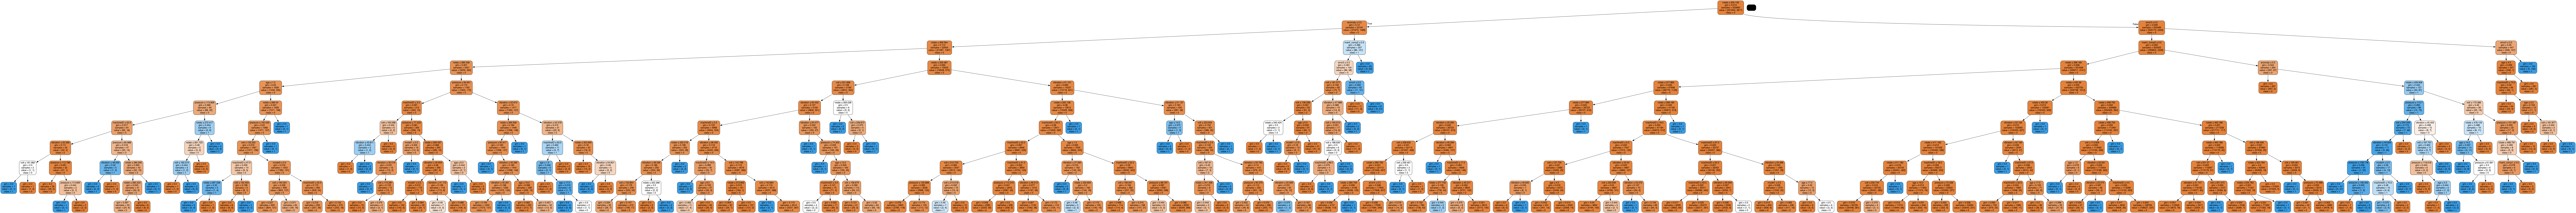

In [38]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model_a, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=list(X_train.columns)[1:], class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

## Model Training In Sagemaker

In [16]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))
role = 'arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579'
print("RoleArn: {}".format(role))

AWS Region: us-west-1
RoleArn: arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579


In [17]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 500
)

746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [18]:
from sagemaker.session import TrainingInput
train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

#### Train It

In [19]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-11-18-02-40-653


2023-02-11 18:02:41 Starting - Starting the training job...
2023-02-11 18:03:09 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
......
2023-02-11 18:04:03 Downloading - Downloading input data...
2023-02-11 18:04:43 Training - Downloading the training image......
2023-02-11 18:05:44 Training - Training image download completed. Training in progress..[2023-02-11 18:05:36.953 ip-10-0-74-188.us-west-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimi

#### Deploy It

In [20]:
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-11-17-28-24-193
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-02-11-17-28-24-193
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-02-11-17-28-24-193


--------!

In [22]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2023-02-11-17-28-24-193'

## Evaluation

In [23]:
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

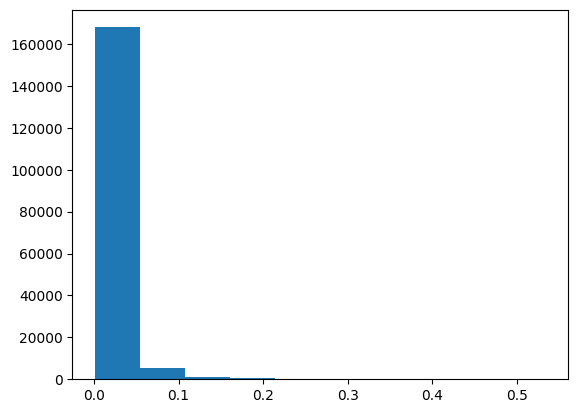

In [24]:
import matplotlib.pyplot as plt

inputd = test.to_numpy()[:,1:]
inputd[:, 0] = 0
inputd[:, 6] = 0
inputd[:, 8] = 0
predictions=predict(inputd)
plt.hist(predictions)
plt.show()

In [25]:
import sklearn

cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[172736      3]
 [  2481      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    172739
           1       0.00      0.00      0.00      2481

    accuracy                           0.99    175220
   macro avg       0.49      0.50      0.50    175220
weighted avg       0.97      0.99      0.98    175220



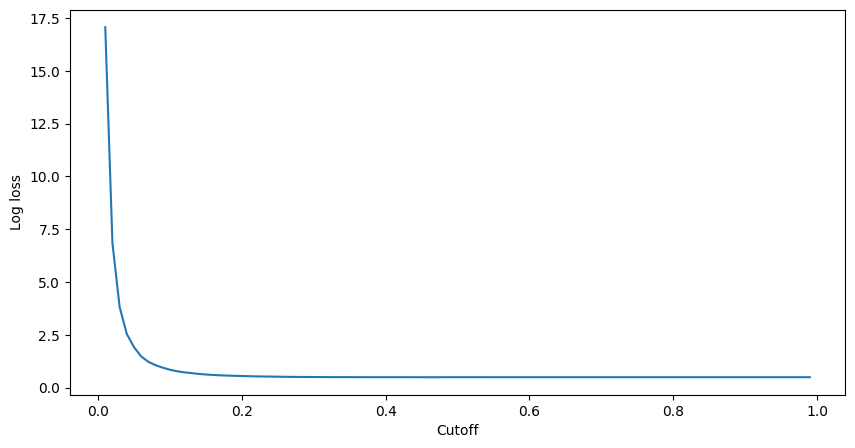

In [26]:
import matplotlib.pyplot as plt

cutoffs = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoffs:
    log_loss.append(
        sklearn.metrics.log_loss(test.iloc[:, 0], np.where(predictions > c, 1, 0))
    )

plt.figure(figsize=(10,5))
plt.plot(cutoffs, log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [27]:
print(
    'Log loss is minimized at a cutoff of ', cutoffs[np.argmin(log_loss)], 
    ', and the log loss value at the minimum is ', np.min(log_loss)
)

Log loss is minimized at a cutoff of  0.46 , and the log loss value at the minimum is  0.48845503883447083


In [40]:
predictions=predict(inputd[:20])
print(predictions)

[0.01656838 0.00215282 0.2324357  0.02219372 0.01384743 0.10336875
 0.2026487  0.21061452 0.00435823 0.02516961 0.0575682  0.02390198
 0.01143255 0.00738803 0.05368387 0.68556291 0.22499888 0.01922979
 0.16705067 0.05245109]


In [44]:
test_df = pd.read_csv("s3://pmpf-data/sagemaker-xgboost-prediction/data/test.csv", header=None)

In [60]:
test_df.iloc[[4]].values.flatten().tolist()

[0,
 '2015-04-15 21:00:00',
 8,
 206.90745931761,
 365.906652649601,
 82.3334184313073,
 44.3221267828272,
 2,
 16,
 0,
 15.423573400301713,
 172.14114110151047,
 63.97927074096405,
 430.3166127053947,
 4.480287503984723,
 39.44384547915708,
 9.040781699434756,
 98.51130979933748]